In [77]:
# This notebook shows an example of how to decode the data in the EvAAL API format to pandas DataFrame.
# Please note that the format of the txt file in ../trials/ is what returned through EvAAL API in the competition.
# In the real competition in September, you need to get data throught EvAAL API.
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sub import estimate

importlib.reload(estimate)

plt.rcParams["figure.figsize"] = (16.0, 6.0)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [78]:
# LOG_FILE_PATH = "../trials/Track5_second_evaluation_01_pdr.txt"
LOG_FILE_PATH = "../trials/4_1_51.txt"
GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [79]:
from sub import pdr

importlib.reload(pdr)

data = pdr.read_log_data(LOG_FILE_PATH)
acc_df, gyro_df, mgf_df, ground_truth_df, ble_scans_df = pdr.convert_to_dataframes(data)
ble_positions_df = pd.read_csv(BEACON_LIST_PATH)

In [80]:
acc_df["norm"] = np.sqrt(acc_df["x"] ** 2 + acc_df["y"] ** 2 + acc_df["z"] ** 2)

In [81]:
acc_df["norm"] = np.sqrt(acc_df["x"] ** 2 + acc_df["y"] ** 2 + acc_df["z"] ** 2)
# 時間が25秒以上50秒未満のデータを抽出
time_filter_acc = acc_df[(acc_df.ts >= 25) & (acc_df.ts < 35)]
time_filter_acc.reset_index(inplace=True, drop=True)

In [82]:
# 移動平均フィルターをかける
time_filter_acc.loc[:, "rolling_norm"] = time_filter_acc["norm"].rolling(10).mean()

/var/folders/9p/p2bfdpzj5v5fs4xvn07kwlww0000gn/T/ipykernel_62775/259520140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filter_acc.loc[:, "rolling_norm"] = time_filter_acc["norm"].rolling(10).mean()


In [83]:
# ピーク検出
from scipy.signal import find_peaks

peaks, _ = find_peaks(time_filter_acc["rolling_norm"], height=12, distance=20)

In [84]:
acc_df["rolling_norm"] = acc_df["norm"].rolling(10).mean()

peaks, _ = find_peaks(acc_df["rolling_norm"], height=12, distance=10)

In [85]:
gyro_in_step_timing = pd.DataFrame()
# ピーク時のジャイロの値を取得
gyro_in_step_timing = estimate.match_data(gyro_df, acc_df.ts[peaks])

In [86]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 角度データフレームの生成
angle_df = estimate.convert_to_angle_from_gyro(gyro_df)

# 0秒から20秒までのデータを抽出
time_filtered_df = angle_df

# フィルタリングされたデータでピーク値の検出
peaks, _ = find_peaks(time_filtered_df["x"])

In [87]:
peaks, _ = find_peaks(acc_df["rolling_norm"], height=12)

In [88]:
# ジャイロを積分して角度に変換
angle_in_step_timing = pd.DataFrame()
angle_in_step_timing = estimate.match_data(angle_df, acc_df.ts[peaks])

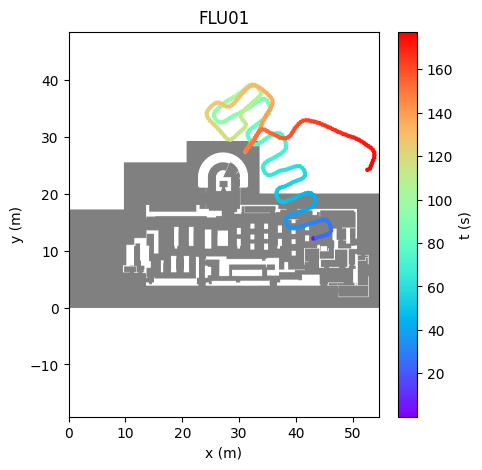

In [89]:
from sub import utils

importlib.reload(utils)

# 1 pixel of bmp represents 0.01 m

dx = 0.01
dy = 0.01

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = estimate.load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp",
    )
floor_name = ground_truth_df["floor_name"][0]

peek_angle = estimate.convert_to_peek_angle(gyro_df, acc_df, peaks)
cumulative_displacement_df = estimate.calculate_cumulative_displacement(
    peek_angle.ts,
    peek_angle["x"],
    0.5,
    {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
    ground_truth_df["ts"][0],
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    cumulative_displacement_df,
)

[90.83023906]
           ts          bdaddress  rssi          x          y  height  \
0    5.439220  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
1    5.547211  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
2    5.653872  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
3    5.754841  C0:1C:4D:44:32:56   -71  43.500000  10.600000    1.75   
4    5.864267  C0:1C:4D:44:32:56   -71  43.500000  10.600000    1.75   
5    6.069584  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
6    6.273701  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
7   11.546024  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
8   11.744088  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
9   12.391566  C0:1C:4D:44:32:56   -69  43.500000  10.600000    1.75   
10  12.487702  C0:1C:4D:44:32:56   -69  43.500000  10.600000    1.75   
11  12.596353  C0:1C:4D:44:32:56   -69  43.500000  10.600000    1.75   
12  12.698442  C0:1C:4D:44:32:56   -69  43.500000 

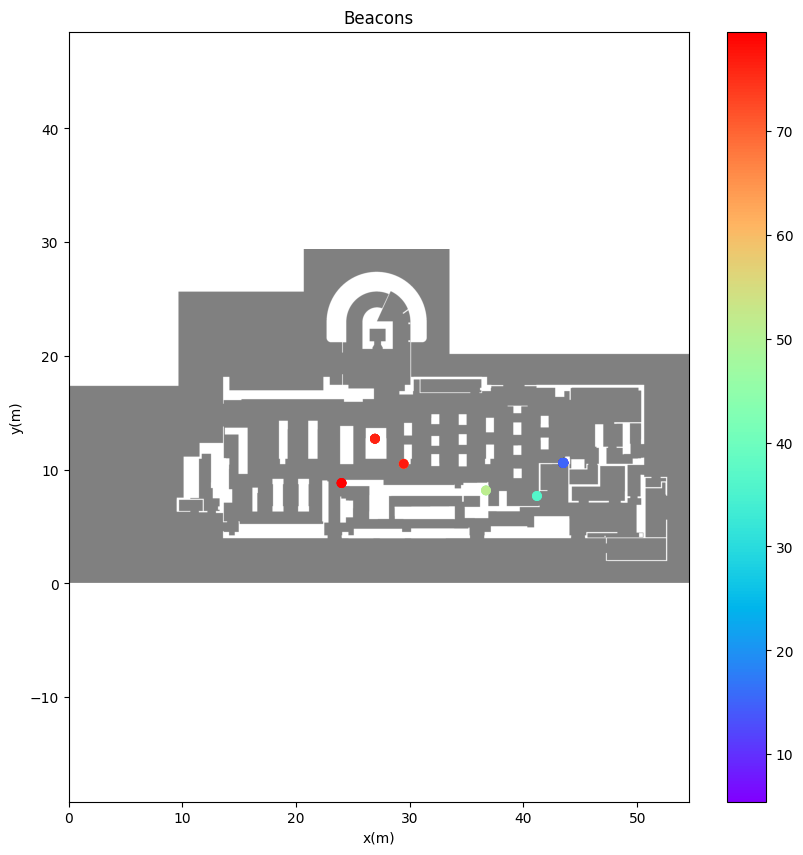

In [97]:
import numpy as np
import pandas as pd

# 軌跡前半の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索
# これは軌跡前半はドリフトが乗りづらいため
# 時間全体の中央を変数に入れる
center_of_time = ble_scans_df.tail(1)["ts"].to_numpy() / 2

first_half_strong_blescans = estimate.filter_strong_blescans(
    ble_scans_df,
    80,
    -73,
)
merged_strong_blescans_first_half = estimate.load_beacons_and_merge(
    BEACON_LIST_PATH,
    first_half_strong_blescans,
)


# マップ上にビーコンの位置をプロット
estimate.plot_map(map_dict, floor_name, dx, dy)

plt.colorbar(
    plt.scatter(
        merged_strong_blescans_first_half.x,
        merged_strong_blescans_first_half.y,
        c=merged_strong_blescans_first_half["ts"],
        cmap="rainbow",
    ),
)

plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.title("Beacons")
plt.show()

           ts          bdaddress  rssi          x          y  height  \
0    5.439220  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
1    5.547211  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
2    5.653872  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
3    5.754841  C0:1C:4D:44:32:56   -71  43.500000  10.600000    1.75   
4    5.864267  C0:1C:4D:44:32:56   -71  43.500000  10.600000    1.75   
5    6.069584  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
6    6.273701  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
7   11.546024  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
8   11.744088  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
9   12.391566  C0:1C:4D:44:32:56   -69  43.500000  10.600000    1.75   
10  12.487702  C0:1C:4D:44:32:56   -69  43.500000  10.600000    1.75   
11  12.596353  C0:1C:4D:44:32:56   -69  43.500000  10.600000    1.75   
12  12.698442  C0:1C:4D:44:32:56   -69  43.500000  10.600000    

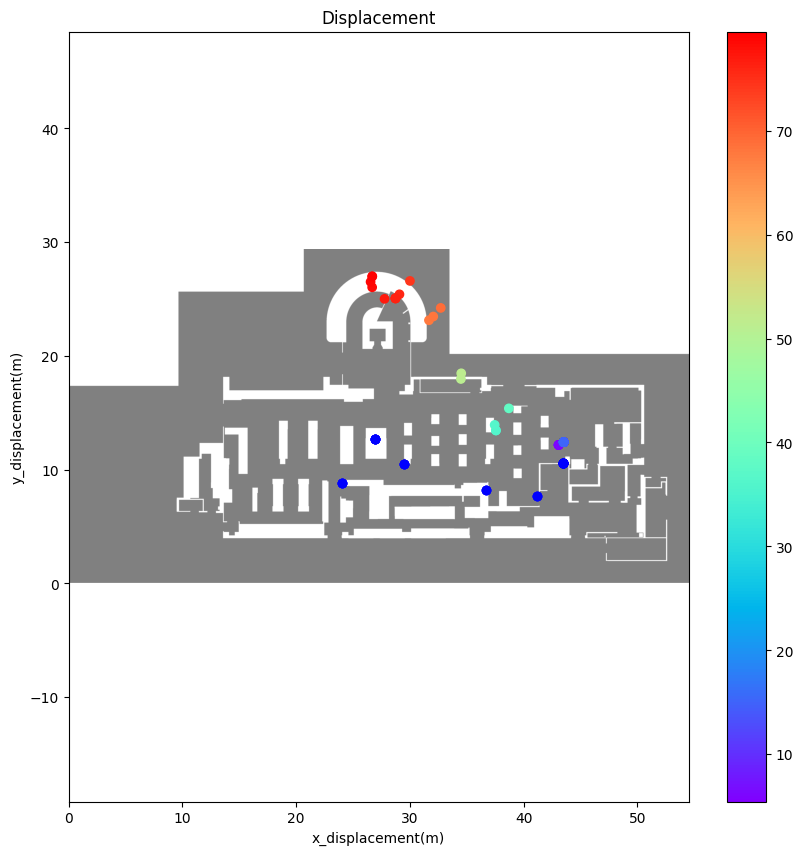

In [91]:
rotated_cumulative_displacement_df = estimate.rotate_cumulative_displacement(
    cumulative_displacement_df,
    0.3,
    {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
)


# 同じ bdaddress, x, y を持つデータをグループ化
merged_df = pd.merge_asof(
    merged_strong_blescans_first_half,
    rotated_cumulative_displacement_df,
    on="ts",
    direction="nearest",
)

print(merged_df)


# マップ上にx_displacement,y_displacementとビーコンの位置をプロット
estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        merged_df.x_displacement,
        merged_df.y_displacement,
        c=merged_df["ts"],
        cmap="rainbow",
    ),
)

# plt.colorbar(
# plt.scatter(
# merged_df.x,
# merged_df.y,
# c=merged_df["ts"],
# cmap="rainbow",
# ),
# )

plt.scatter(merged_df.x, merged_df.y, c="blue")


plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

In [92]:
from sub import drift

first_time_remove_drift_angle, first_time_remove_drift_angle_displacement = (
    drift.remove_drift_in_angle_df(
        acc_df,
        angle_df,
        ground_truth_df,
    )
)

Index(['ts', 'bdaddress', 'rssi'], dtype='object')
Index(['bdaddress', 'x', 'y', 'height', 'control_number', 'floorname'], dtype='object')


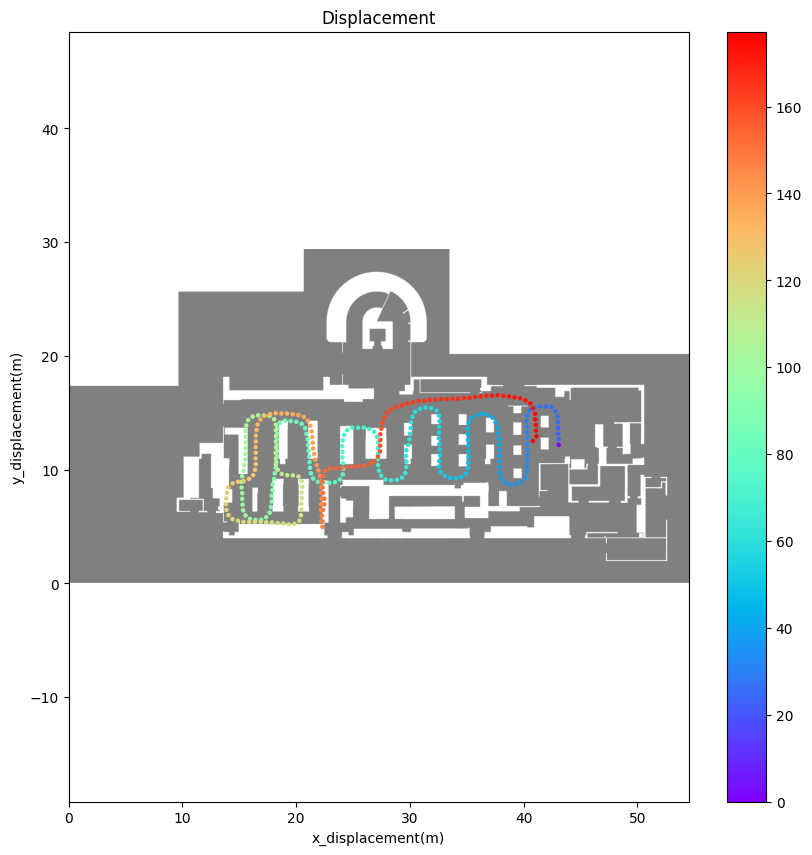

In [93]:
from sub import ble

importlib.reload(ble)

print(ble_scans_df.columns)
print(ble_positions_df.columns)


rotated_optimal_angle_df, rotated_optimal_displacement_df = (
    ble.rotate_trajectory_to_optimal_alignment_using_ble(
        acc_df,
        first_time_remove_drift_angle,
        ble_scans_df,
        ble_positions_df,
        ground_truth_first_point={
            "x": ground_truth_df.x[0],
            "y": ground_truth_df.y[0],
        },
    )
)


estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        rotated_optimal_displacement_df.x_displacement,
        rotated_optimal_displacement_df.y_displacement,
        c=rotated_optimal_displacement_df.ts,
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

               ts          x
0        0.003125   1.488564
1        0.013075   1.487014
2        0.023024   1.485458
3        0.032974   1.483902
4        0.042923   1.482358
5        0.052873   1.480801
6        0.062822   1.479214
7        0.072772   1.477548
8        0.082721   1.475857
9        0.092671   1.474167
10       0.102620   1.472519
11       0.112570   1.470969
12       0.122519   1.469553
13       0.132469   1.468302
14       0.142418   1.467240
15       0.152368   1.466386
16       0.162317   1.465728
17       0.172267   1.465296
18       0.182216   1.465187
19       0.192166   1.465274
20       0.202115   1.465575
21       0.212065   1.466034
22       0.222014   1.466573
23       0.231964   1.467143
24       0.241914   1.467688
25       0.251863   1.468147
26       0.261812   1.468546
27       0.271762   1.468865
28       0.281712   1.469129
29       0.291661   1.469387
30       0.301611   1.469620
31       0.311560   1.469878
32       0.321510   1.470216
33       0.331

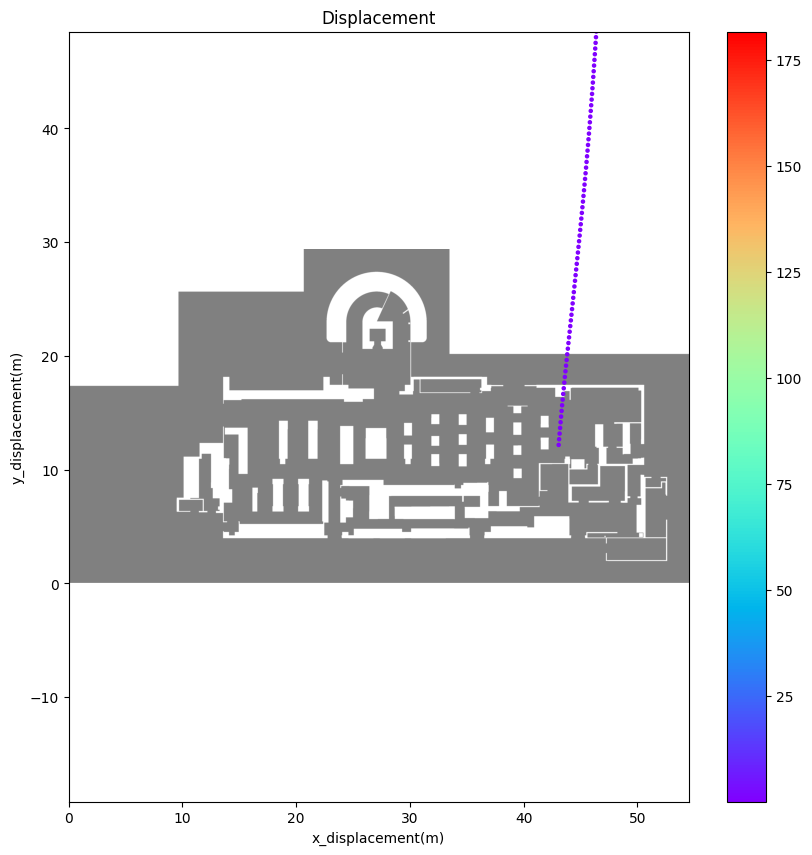

In [94]:
print(rotated_optimal_angle_df)

optimal_drift_and_euclidean = estimate.search_optimal_drift_from_angle(
    rotated_optimal_angle_df,
    ground_truth_df,
)


first_time_remove_drift_angle = pd.DataFrame(
    {
        "ts": rotated_optimal_angle_df.ts,
        "x": rotated_optimal_angle_df.x
        - optimal_drift_and_euclidean["drift"]
        * (rotated_optimal_angle_df.ts - rotated_optimal_angle_df.ts.iloc[0]),
    },
)

# first_time_remove_drift_angle= pd.DataFrame({
#     "ts":rotated_optimal_angle_df.ts,
#     "x":rotated_optimal_angle_df.x-0.002999999999999989*(rotated_optimal_angle_df.ts-rotated_optimal_angle_df.ts.iloc[0])
# })


first_time_remove_drift_angle_displacement = estimate.calculate_cumulative_displacement(
    first_time_remove_drift_angle.ts,
    first_time_remove_drift_angle["x"],
    0.5,
    {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
    ground_truth_df["ts"][0],
)

estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        first_time_remove_drift_angle_displacement.x_displacement,
        first_time_remove_drift_angle_displacement.y_displacement,
        c=first_time_remove_drift_angle_displacement.ts,
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

In [95]:
# 軌跡全体の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索見つける
overall_strong_blescans = estimate.filter_strong_blescans(
    ble_scans_df,
    ble_scans_df.tail(1)["ts"].values[0],
    -76,
)
merged_strong_blescans_overall = estimate.load_beacons_and_merge(
    BEACON_LIST_PATH,
    overall_strong_blescans,
)

overall_strong_ble_angle = estimate.search_optimal_angle(
    first_time_remove_drift_angle_displacement,
    ground_truth_df,
    merged_strong_blescans_overall,
)

rotate_by_overall_strong_ble_angle = pd.DataFrame(
    {
        "ts": first_time_remove_drift_angle.ts,
        "x": first_time_remove_drift_angle.x + overall_strong_ble_angle,
    },
)


rotate_by_overall_strong_ble_angle_displacement = (
    estimate.calculate_cumulative_displacement(
        rotate_by_overall_strong_ble_angle.ts,
        rotate_by_overall_strong_ble_angle["x"],
        0.5,
        {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
        ground_truth_df["%time"][0],
    )
)

estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        rotate_by_overall_strong_ble_angle_displacement.x_displacement,
        rotate_by_overall_strong_ble_angle_displacement.y_displacement,
        c=rotate_by_overall_strong_ble_angle_displacement.ts,
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

KeyError: '%time'

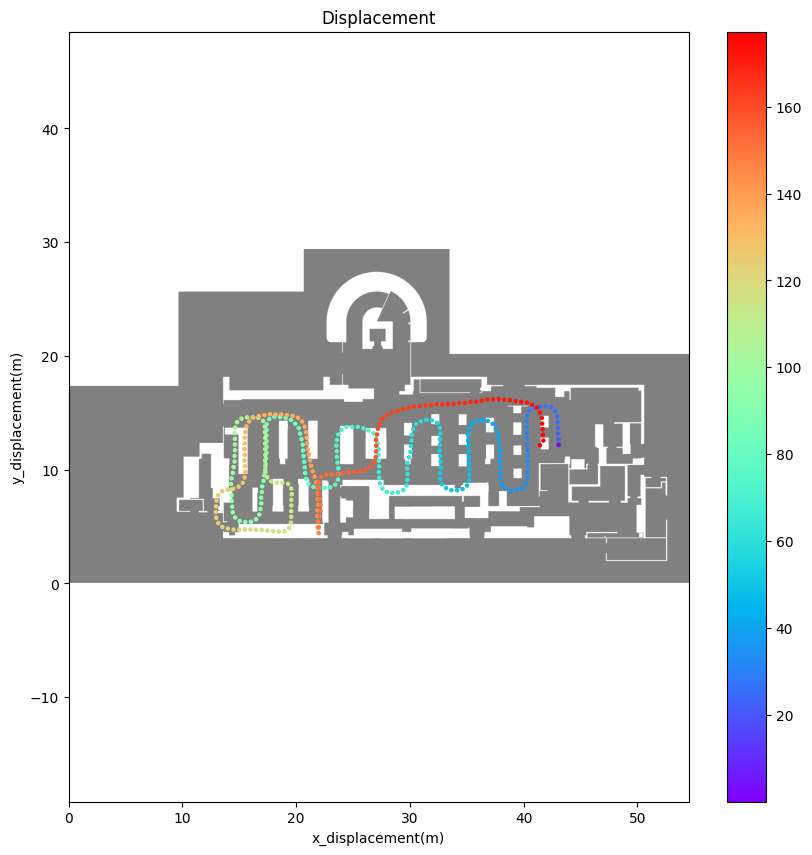

In [ ]:
second_optimal_drift_and_euclidean = estimate.search_optimal_drift_from_angle(
    rotate_by_overall_strong_ble_angle,
    ground_truth_df,
)

second_time_remove_drift_angle = pd.DataFrame(
    {
        "ts": rotate_by_overall_strong_ble_angle.ts,
        "x": rotate_by_overall_strong_ble_angle.x
        - second_optimal_drift_and_euclidean["drift"]
        * (
            rotate_by_overall_strong_ble_angle.ts
            - rotate_by_overall_strong_ble_angle.ts.iloc[0]
        ),
    },
)

second_time_remove_drift_angle_displacement = (
    estimate.calculate_cumulative_displacement(
        second_time_remove_drift_angle.ts,
        second_time_remove_drift_angle["x"],
        0.5,
        {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
        ground_truth_df["%time"][0],
    )
)

estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        second_time_remove_drift_angle_displacement.x_displacement,
        second_time_remove_drift_angle_displacement.y_displacement,
        c=second_time_remove_drift_angle_displacement.ts,
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

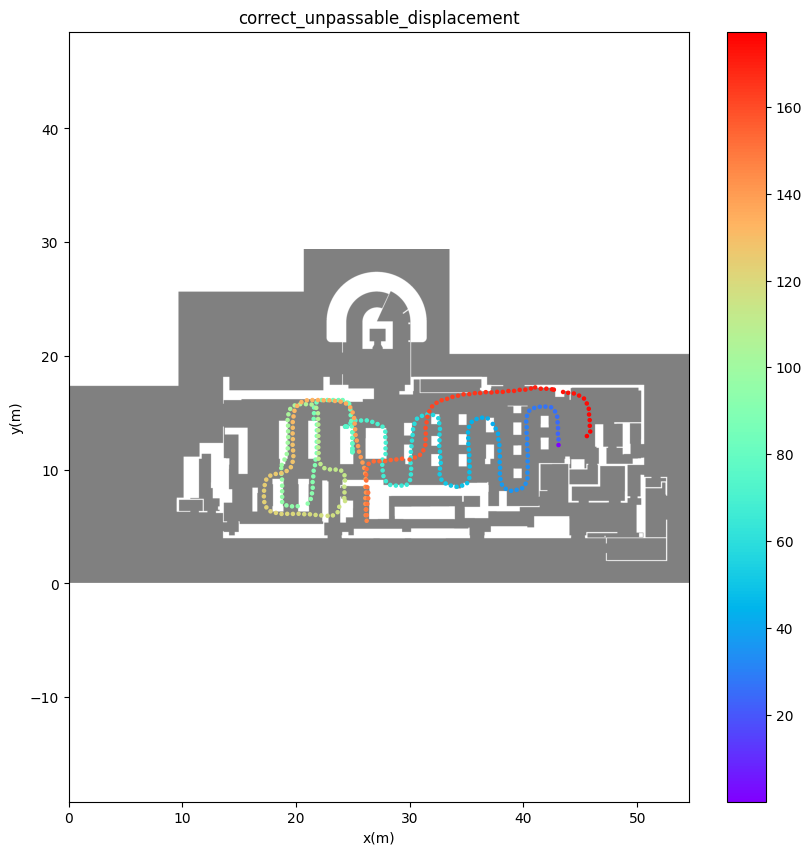

In [ ]:
np.set_printoptions(threshold=np.inf)

correct_unpassable_displacement = estimate.correct_unpassable_points(
    second_time_remove_drift_angle_displacement[
        second_time_remove_drift_angle_displacement["ts"] < 180
    ],
    map_dict,
    floor_name,
    dx,
    dy,
)

estimate.plot_map(
    map_dict,
    floor_name,
    dx,
    dy,
)

plt.colorbar(
    plt.scatter(
        correct_unpassable_displacement["x_displacement"],
        correct_unpassable_displacement["y_displacement"],
        c=correct_unpassable_displacement["ts"],
        cmap="rainbow",
        s=5,
    ),
)


plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.title("correct_unpassable_displacement")
plt.show()


output_df = pd.DataFrame(
    {
        "ts": correct_unpassable_displacement["ts"],
        "x": correct_unpassable_displacement["x_displacement"],
        "y": correct_unpassable_displacement["y_displacement"],
        "floor": floor_name,
    },
)